[View in Colaboratory](https://colab.research.google.com/github/plouismarie/pytorchMnist-medium/blob/master/pyTorch_Mnist_medium.ipynb)

>[Quick Introduction to computer vision with MNIST and Pytorch.](#scrollTo=RmXc2y0rmSoA)

>>>[Computer Vision](#scrollTo=RmXc2y0rmSoA)



# Quick Introduction to computer vision with MNIST and Pytorch.


Who should read ? :
This tutorial is for beginner in AI, looking for practical code I am happy to share, or people who want to refresh their basic knowledge about AI and computer vision.

Which Framework ? :
Pytorch

How long to read ? :
~7 mn

The Goal ? : We will see how to use AI to recognize an handwritten digit of yours, along to some common errors that are explained and solved.

<u>Intro</u>: When you are a beginner in AI and computer vision, it is easy to get confused with all the terminologies.
“you could create a successful net without understanding how it worked”
This will remain high level and will not go to deep math theory, then my readers stay up to the end of the article ;) but coding section would be practical and complete.

Let’s start with some popular terms, just a small selection to start with, and see why it is required to be clear on that.

### Computer Vision

We use a network of digital neurons to give machine the aptitude to recognize a shape, an object or a living entity from a picture, close to the human being efficiency. Back in the end of the 50's, one of an early machine learning classifier was actually named perceptron, for digital perception.

![image.png](image.png)

<i>image from Michael Steven's youtube video : What Is The Resolution Of The Eye?</i>

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision torchsummary
!pip install --no-cache-dir -I pillow
print(accelerator)

tcmalloc: large alloc 1073750016 bytes == 0x560ec000 @  0x7f548c5fb1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 2.0MB 26.2MB/s 
cu80


In [2]:
# import all the needed libraries

import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable

import random
import matplotlib.pyplot as plt
%matplotlib inline

from torch import optim
from torch.nn.parameter import Parameter
import torch.nn.init as init
import numpy as np
import math,os

from PIL import Image,ImageOps

print('##Import : OK')

##Import : OK


In [3]:
# device variable will be used later to point to appropriate device directly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)#shows cuda if gpu is detected else shows cpu
print("Pytorch: {}".format(torch.__version__))

cuda
Pytorch: 0.4.1


In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # python 3 allows quick syntax here instead of using super(Net,self)  
        self.conv1 = nn.Conv2d(
            1, #input
            10, #output nb_filters
            stride=1, #filter step
            kernel_size=5) #filter size
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # randomly zero some input - default is 50%
        self.fc1 = nn.Linear(320, 50) # fully connected layer
        self.fc2 = nn.Linear(50, 10) # output is 10 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # reshape
        x = F.relu(self.fc1(x)) # activation
        x = F.dropout(x, training=self.training)# dropout prevents the model from placing too much trust in any of the input features
        x = self.fc2(x) # reduce the output
        return F.log_softmax(x, dim=1)

In [14]:
def getnormalization_values(): 
    train_dataset=torchvision.datasets.MNIST(root='data/', train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
    mean=float(train_dataset.train_data.float().mean()/255)
    std=float(train_dataset.train_data.float().std()/255)
    train_sample=train_dataset[0][0]
    return mean,std,train_sample
# for dataset with color and natural image, like Cifar, formula would be different
# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/12

# hyper parameters
batch_size = 32

mean,std,x00=getnormalization_values()

#Define transformations
transformations = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((mean,mean,mean),(std,std,std))
])

# get datasets, with the auto extracted normalization values
train_dataset = torchvision.datasets.MNIST(root='data/', train=True, transform=transformations, download=True)
test_dataset = torchvision.datasets.MNIST(root='data/', train=False, transform=transformations)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

id=random.randint(0,len(train_loader))
sample=train_dataset[id][0]
#pic_height = 28 # let's not hardcode it and let the code guess it 
#pic_weight = 28 # by extracting actual value from the training set
pic_height=tuple(sample.size())[1] #28 for mnist, 32 for cifar, 224 for imagenet
pic_weight=tuple(sample.size())[2] #28 for mnist, 32 for cifar, 224 for imagenet

print('dataset is ready')
print('dataset dimension:',tuple(sample.size()))

print('Number of elements:',list(train_dataset.train_data.size())[0])

Processing...
Done!
dataset is ready
dataset dimension: (1, 28, 28)
Number of elements: 60000


In [5]:
# The learning rate function below dynamically adjusts itself

def isNotImproving(acc_list,nbitems):
    # https://stackoverflow.com/questions/30647330/calculate-if-trend-is-up-down-or-stable
    acc_list=acc_list[-nbitems:]
    A10=sum(range(nbitems+1))
    B10=sum(acc_list)
    C10=0
    for i in range(nbitems): C10=C10 + (i+1) * acc_list[i]
    D10=0
    for i in range(nbitems): D10=D10 + (i+1) * (i+1)
    b=(nbitems * C10 - A10 * B10) / (nbitems * D10 - A10 * A10)
    #print('b:',b)
    if b <= 0: return True
    return False

def adaptive_learning_rate(count,optimizer,lr,acc_list,patience=3,nbitems=5):
    if len(acc_list) > nbitems:
        if isNotImproving(acc_list,nbitems):
            count+=1  
            print('===non increasing trend detected-',count,'/',patience)
    if count >= patience:
        print('===patience is exceeded-steppingLR')
        lr=lr/10
        count=0
        state_dict=optimizer.state_dict()
        for param_group in state_dict['param_groups']:
            param_group["lr"]=lr
        optimizer.load_state_dict(state_dict)
    return count,optimizer,lr

# train the model

def train(model,train_loader,optimizer,learning_rate,num_epochs,criterion,device,pic_weight,pic_height):
    train_loss_list,train_accuracy_list=[],[]
    train_accuracy,total,count=0,0,0
    for epoch in range(num_epochs):
        model.train()
        for i,(images,labels) in enumerate(train_loader):
            images=images.to(device)
            labels = labels.to(device)
            if torch.cuda.is_available(): model.cuda()
            outputs=model(images)
            #compute the loss based on the predictions and actual labels
            train_loss=criterion(outputs,labels)
            #Accuracy
            _,prediction=torch.max(outputs.data,1)
            total += labels.size(0)
            train_accuracy += (prediction == labels).sum().item()
            #Clear all accumulated gradients            
            optimizer.zero_grad()
            #Backpropagate the loss
            train_loss.backward()
            #adjust parameters according to the computed gradients
            optimizer.step()
            #display some stats
            if (i+1) % 100 == 0:
                train_accuracy_pct=100 * train_accuracy / total
                print ('Epoch [{}/{}], Step [{}/{}], Accuracy [{}/{}] {:.2f}%, Loss: {:.4f}, lr:{}'.format(
                  epoch+1, num_epochs,
                  i+1, len(train_loader),
                  train_accuracy,total,train_accuracy_pct,
                  train_loss.item(),
                  learning_rate))
                train_loss_list.append(train_loss.item()) #then we could plot the loss
                train_accuracy_list.append(train_accuracy_pct) #then we will plot the accuracy
                count,optimizer,learning_rate=adaptive_learning_rate(count,optimizer,learning_rate,train_accuracy_list)
    return train_loss_list,train_accuracy_list

def display_summary(model,sample):
    try:
        summary(model,tuple(sample.size()))
    except:
        print(model) # display AI model in use
        print('Total params: ',sum([param.nelement() for param in model.parameters()]))

model=Net().to(device)
display_summary(model,sample)

NameError: ignored

In [0]:

# Loss and optimizer
learning_rate = 0.001 # to start with, then it will dynamically adjusts itself if needed
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [0]:
%%time
# train
num_epochs = 16
all_losses,all_accuracies = train(model, train_loader, optimizer,learning_rate, num_epochs, criterion, device,pic_weight,pic_height )

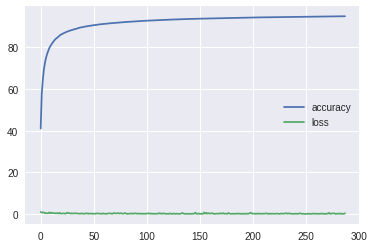

In [11]:
# draw accuracy and loss chart

plt.figure()
line_acc,=plt.plot(all_accuracies,label='accuracy') #blue
line_loss,=plt.plot(all_losses,label='loss') #orange
plt.legend(handles=[line_acc, line_loss])
plt.show()

In [0]:
def test(model,test_loader,criterion,device,pic_height,pic_weight):
    model.eval()
    with torch.no_grad():
        test_loss,test_accuracy=0.0,0.0
        for images,labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            if torch.cuda.is_available(): model.cuda()
            outputs=model(images)
            test_loss += criterion(outputs,labels).item()
            _,prediction=torch.max(outputs.data,1)
            test_accuracy += (prediction == labels).sum().item()
        test_loss = test_loss / len(test_loader.dataset)
        print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss,
        int(test_accuracy),len(test_loader.dataset),100 * float(test_accuracy) / len(test_loader.dataset)))


In [37]:
#save it in the VM
model_dir = './data/pytorch_model'
model_nickname='/net'
if not os.path.exists(model_dir): os.makedirs(model_dir)
torch.save(model.state_dict(), model_dir + model_nickname)

print('model is saved in :',model_dir + model_nickname)


model is saved in : ./data/pytorch_model/net


In [38]:
# save it in Drive
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'filename.h5'})
uploaded.SetContentFile('./data/pytorch_model/net')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1WJcZGiGNnWHY7PTYfxquAPQitgzPdOVH


In [7]:
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)# Load a file by ID.
downloaded = drive.CreateFile({'id': '1WJcZGiGNnWHY7PTYfxquAPQitgzPdOVH'})
downloaded.GetContentFile('filename.h5')
print('file is downloaded')
model=Net().to(device)
model.load_state_dict(torch.load('filename.h5'))
print('model is ready')
#model.load_weights('last_weights.mat')

file is downloaded


In [0]:
model=Net().to(device)


downloaded.GetContentFile('filename.h5')
model.load_state_dict(torch.load('filename.h5'))
#model.load_weights('last_weights.mat')

In [9]:
display_summary(model,sample)
print('Trained Model:',model_dir + model_nickname, 'loaded successfully')

NameError: ignored

In [0]:
# test
test(model,test_loader,criterion,device,pic_height,pic_weight)

In [19]:
#prediction with test set

id=20 #9
x0=test_dataset[id][0]
x=Variable(x0.unsqueeze(0))
#x=x.cuda()
x=x.to(device)

outputs=model(x)

_,prediction=torch.max(outputs.data,1)
expectation=test_dataset[id][1]
result_softmax=F.softmax(outputs[0],dim=0)[prediction].data[0]
# display prediction, % of certainty, actual digit in the test set
print("prediction: {} - softmax: {} - correct value: {}".format(prediction[0],result_softmax,expectation))
#display normalized image

!pip install --no-cache-dir -I pillow

transforms.ToPILImage()(x0)

prediction: 9 - softmax: 0.9907447695732117 - correct value: 9
    100% |████████████████████████████████| 2.0MB 19.5MB/s 


AttributeError: ignored

<PIL.Image.Image image mode=L size=28x28 at 0x7F9E314C3908>

In [26]:
#prediction with custom set

image = Image.open('newnew3.png') # just use the upload feature in google colab

#import requests
#image = Image.open(requests.get('https://plouismarie.github.io/ml/cv.png', stream=True).raw) # just use the upload feature in google colab
#from urllib.request import urlopen
#image = Image.open(urlopen('https://plouismarie.github.io/ml/cv.png')) # just use the upload feature in google colab

correct=3

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,mean,mean),(std,std,std))
])

image_tensor = transformations(image).float()

print(image_tensor.size())
#print(image_tensor.dim())
#print(image_tensor.type())

x=Variable(image_tensor.unsqueeze(0).float())
x=x.to(device)

outputs=model(x)

_,prediction=torch.max(outputs.data,1)
result_softmax=F.softmax(outputs[0],dim=0)[prediction].data[0]
print("{} (softmax: {},correct:{})".format(prediction[0],result_softmax,correct))

transforms.ToPILImage()(image_tensor.float())

torch.Size([3, 250, 250])


RuntimeError: ignored

In [27]:
#prediction with custom set
from PIL import Image
image = Image.open('newnew3.png')
correct=3

#https://github.com/sebastianberns/torchvision.transforms.invert
import torchvision.transforms.functional as F2

class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """
    
    def invert(self, img):
        """Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        if not F2._is_pil_image(img):
            raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            rgb = Image.merge('RGB', (r, g, b))
            inv = ImageOps.invert(rgb)
            r, g, b = inv.split()
            inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

transformations = transforms.Compose([
    Invert(),#invertbackground
    transforms.Grayscale(num_output_channels=1), # rgb to grayscale
    transforms.Resize(28),#resize
    transforms.ToTensor(),#to tensor
    transforms.Normalize((mean,mean,mean),(std,std,std))#normalize
])

image_tensor = transformations(image).float()

print(image_tensor.size())
#print(image_tensor.dim())
#print(image_tensor.type())

x=Variable(image_tensor.unsqueeze(0).float())
x=x.to(device)

outputs=model(x)

_,prediction=torch.max(outputs.data,1)
result_softmax=F.softmax(outputs[0],dim=0)[prediction].data[0]
print("{} (softmax: {},correct:{})".format(prediction[0],result_softmax,correct))
#display normalized picture
transforms.ToPILImage()(image_tensor)

torch.Size([1, 28, 28])
3 (softmax: 0.9999889135360718,correct:3)
